## 3.6 ガウス過程回帰モデル：ガウス尤度

### 3.6.1 モデル概要


- ガウス過程回帰では, カーネルと呼ばれる関数によって, データに関する抽象的な知識をガウス過程回帰に反映可能.
- ある確率変数の集合を $\mathbf{F}$ とする. 任意の自然数 $N$ に対して, $f$ を関数として $\mathbf{F}$ から選んだ $N$ 個の確率変数 $\{f(x_1), f(x_2), \dots, f(x_N)\}$ がガウス分布に従うとき, $\mathbf{F}$ をガウス過程と呼び, $f$ はガウス過程に従うという.

$$
\begin{align*}
    f \sim \text{GP}(m(x), k(x, x'))
\end{align*}
$$

- ガウス過程では, 平均関数 $m(x)$ とカーネル関数 $k(x, x')$ によって生成される関数 $f$ の性質が決定する.
    - データの平均値を 0 とする正則化をしておくことで平均関数はゼロベクトルと仮定できるため, その場合にはカーネル関数によってガウス過程の性質が特徴づけられる.

※ 後で加筆する.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import gpytorch
from gpytorch.models import ExactGP

sns.set()

### 3.6.2 実装

$$
\begin{align}
    &y_n = f_n + \varepsilon_n \\
    &\varepsilon_n \sim \mathcal{N}(0, \sigma_y^2)
\end{align}
$$

このとき次のようなガウス分布の尤度関数を定義していることとなる.

$$
\begin{align*}
    p(y_n | f_n) = \mathcal{N}(y_n | f_n, \sigma_y^2)
\end{align*}
$$


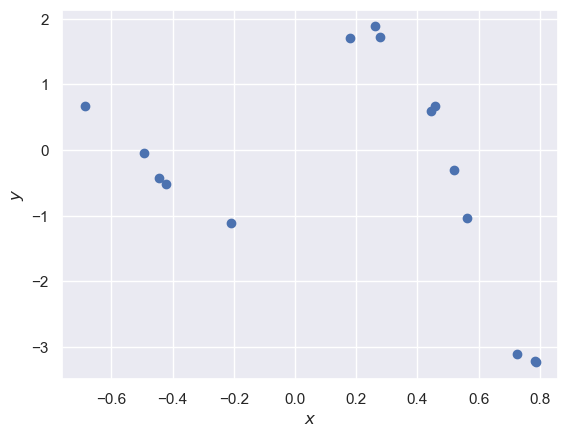

In [3]:
import torch

# データ数
N = 15

# 説明変数 (一様分布からサンプリング)
x_data = torch.FloatTensor(N).uniform_(-1, 1)

# 真の関数
def true_func(x):
    return 1.5 * torch.exp(x) * torch.sin(2 * torch.pi * x)

# 目的変数
y_data = true_func(x_data) + 0.1 * torch.randn(N)

plt.scatter(x_data, y_data)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [7]:
# https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
# ガウス過程回帰モデルの実装
class ExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        # 平均関数
        self.mean_module = gpytorch.means.ConstantMean()

        # カーネル関数
        # カーネルを組み合わせたい場合には, ScaleKernel(RBFKernel() + LinearKernel()) のようにする.
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    # ガウス過程の生成過程
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# 尤度にガウス分布を設定
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# データと尤度を設定しモデルを定義
model = ExactGPModel(x_data, y_data, likelihood)

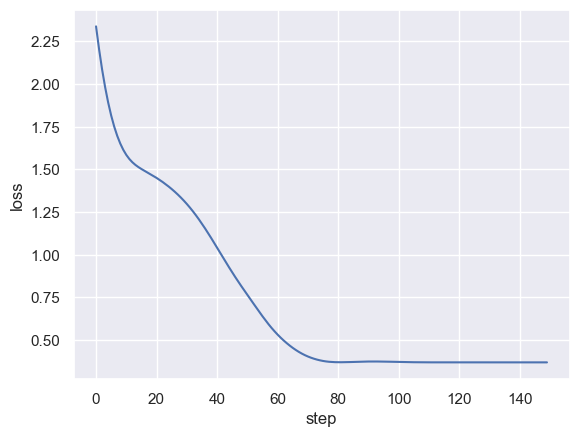

In [9]:
# 学習モードに設定
model.train()
likelihood.train()

# 最適化アルゴリズムに Adam を設定
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# 周辺対数尤度の計算
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 150
loss_list = []
for i in range(training_iter):
    # 勾配を 0 に初期化
    optimizer.zero_grad()

    # モデルからの出力
    output = model(x_data)

    # 損失関数
    loss = - mll(output, y_data)

    # 勾配計算
    loss.backward()

    # パラメータ更新
    optimizer.step()
    loss_list.append(loss.detach().numpy())

plt.plot(loss_list)
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

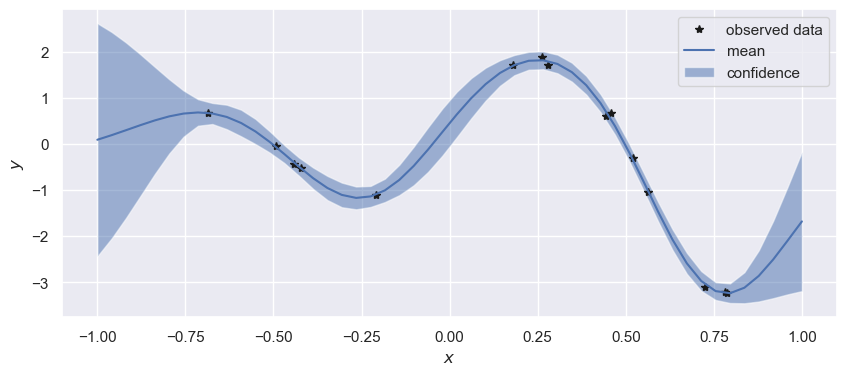

In [12]:
# 推論モードに設定
model.eval()
likelihood.eval()

# テストデータの用意
x_new = torch.linspace(-1, 1, 50)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # 予測分布の出力
    prediction = likelihood(model(x_new))

    # 信用区間の出力
    lower, upper = prediction.confidence_region()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(x_data.numpy(), y_data.numpy(), "k*", label="observed data")
ax.plot(x_new.numpy(), prediction.mean.numpy(), "b", label="mean")
ax.fill_between(x_new.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label="confidence")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.legend()
plt.show()